In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import schema_to_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('com-youtube')
schema = DatasetSchema.load_schema(DATASET.name)
G = schema_to_igraph(schema)

/dd_volume/Development/Python/Thesis/code/env/lib/python3.9/site-packages/igraph/__init__.py:3475: UserWarning: In the first column of 'vertices' NA elements were replaced with string "NA"
  warn("In the first column of 'vertices' NA elements were replaced with string \"NA\"")


In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 1134891
Number of Edges: 5975248
Density: 9.278505075095356e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 10.530082624674968
Median Degree: 2.0


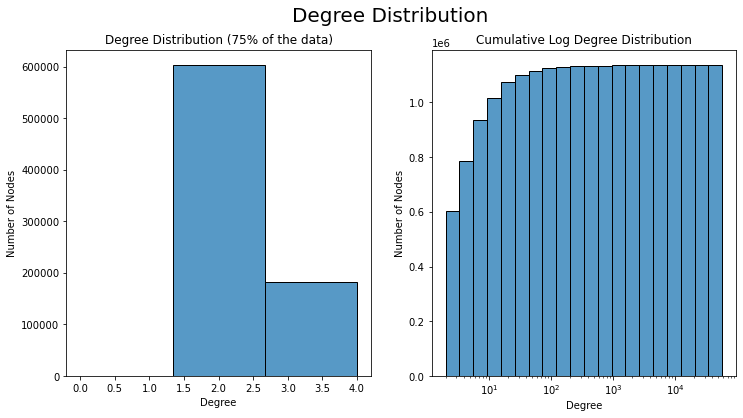

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,57508,1072.0
1,29282,363.0
2,22562,35661.0
3,20922,106.0
4,19524,482709.0
5,17686,663931.0
6,15834,929.0
7,12204,808.0
8,10786,27837.0
9,9798,108624.0


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.088
Diameter: 24


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,1.134890e+06,1.134890e+06,1.134890e+06,1.134890e+06,532351.000000
mean,9.278521e-06,5.098924e-06,1.707101e-04,8.811427e-07,0.172258
std,8.944375e-05,1.463808e-03,9.230393e-04,1.145482e-05,0.300882
min,1.762287e-06,0.000000e+00,8.602316e-29,1.321974e-07,0.000000
25%,1.762287e-06,0.000000e+00,2.126149e-07,1.434609e-07,0.000000
50%,1.762287e-06,0.000000e+00,5.442372e-06,2.391673e-07,0.000000
75%,5.286861e-06,8.991275e-08,4.146848e-05,5.482665e-07,0.194444
max,5.067280e-02,1.000001e+00,4.616386e-01,6.388181e-03,1.000000


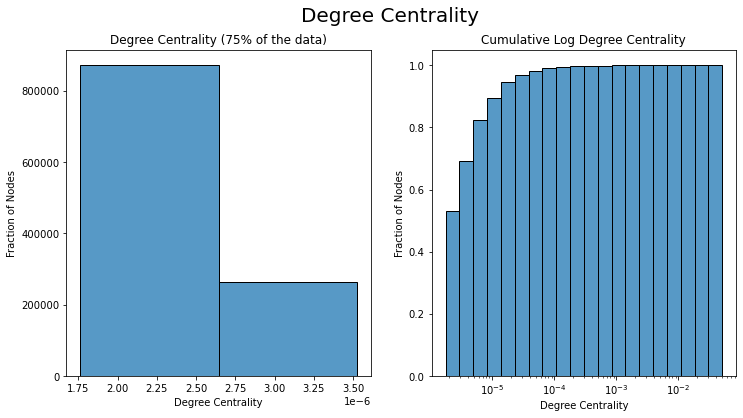

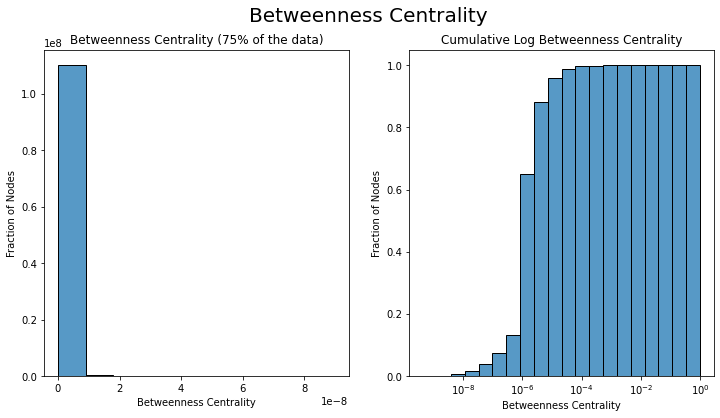

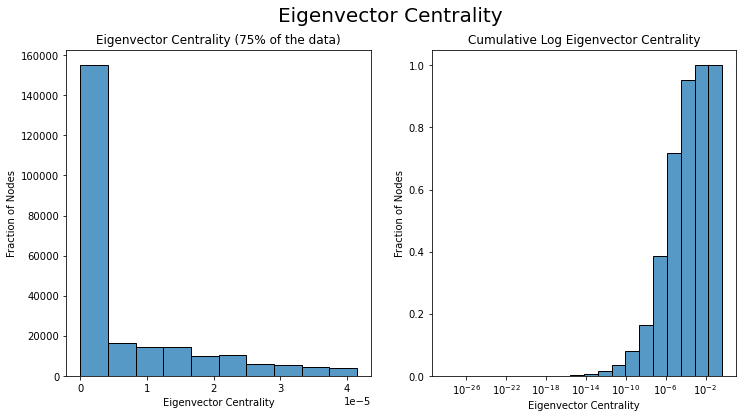

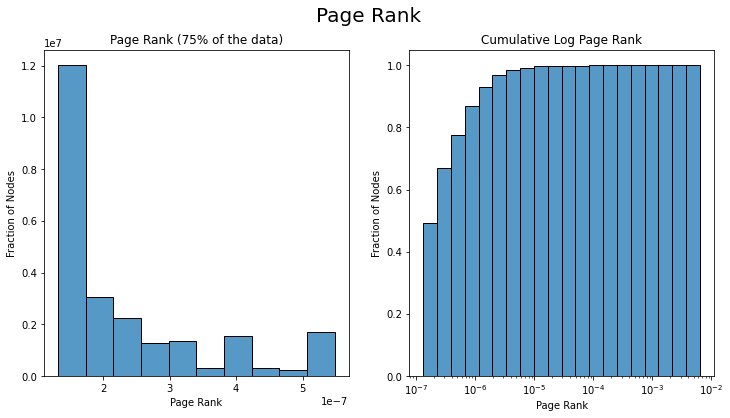

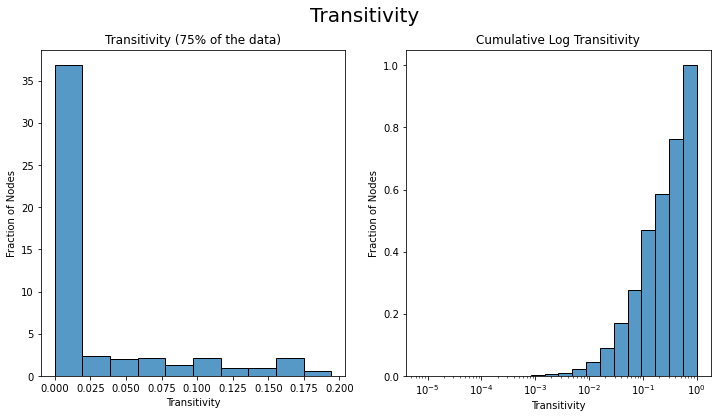

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.050673,1072.0,1.000001,1102244.0,0.461639,1072.0,0.006388,35661.0,1.0,871359.0
1,0.025802,363.0,0.849748,1142174.0,0.228822,363.0,0.003676,1072.0,1.0,85567.0
2,0.019880,35661.0,0.533918,1072.0,0.097320,106.0,0.003213,482709.0,1.0,576199.0
3,0.018435,106.0,0.467370,53223.0,0.084332,1846.0,0.002734,106.0,1.0,974802.0
4,0.017203,482709.0,0.382376,56862.0,0.082068,929.0,0.002406,663931.0,1.0,1021611.0
5,0.015584,663931.0,0.150250,1102242.0,0.077487,2526.0,0.001824,929.0,1.0,223997.0
6,0.013952,929.0,0.150245,701383.0,0.074129,1245.0,0.001476,697672.0,1.0,556521.0
7,0.010753,808.0,0.081036,929.0,0.064858,2687.0,0.001361,808.0,1.0,1039789.0
8,0.009504,27837.0,0.034485,1219.0,0.061515,311.0,0.001293,663606.0,1.0,976122.0
9,0.008633,108624.0,0.029773,1529.0,0.059040,808.0,0.001187,363.0,1.0,475117.0


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 2
Size of the largest component: 1134890


Text(0.5, 1.0, 'Connected Components')

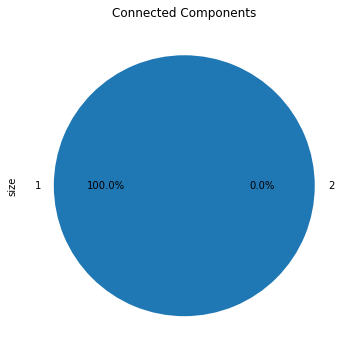

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,1134891,10.530083,2.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

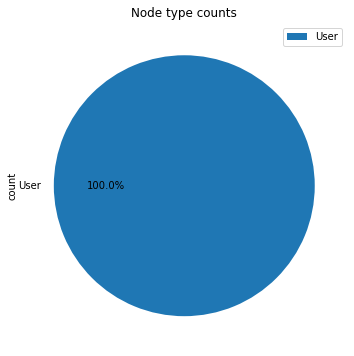

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

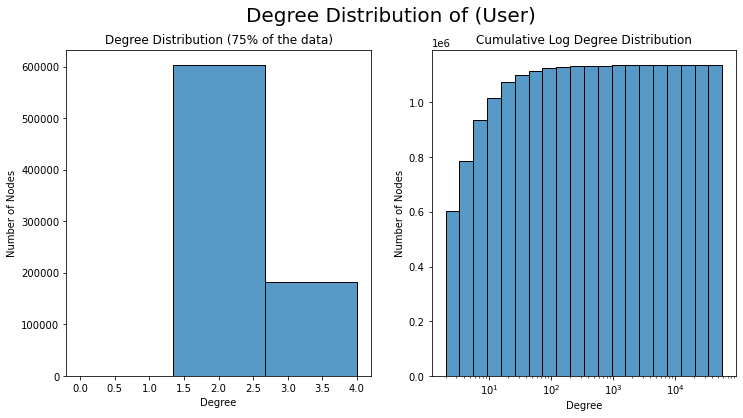

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,57508,1072.0
1,29282,363.0
2,22562,35661.0
3,20922,106.0
4,19524,482709.0
5,17686,663931.0
6,15834,929.0
7,12204,808.0
8,10786,27837.0
9,9798,108624.0


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
FRIENDS,FRIENDS,5975248


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

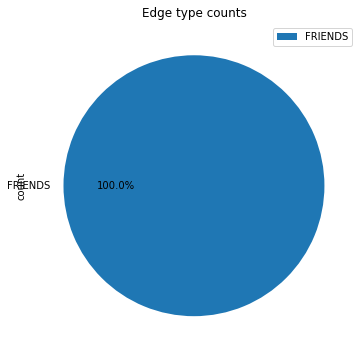

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.050673,1072.0,1.000001,1102244.0,0.461639,1072.0,0.006388,35661.0,1.0,415805.0
1,0.025802,363.0,0.849748,1142174.0,0.228822,363.0,0.003676,1072.0,1.0,688064.0
2,0.019880,35661.0,0.533918,1072.0,0.097320,106.0,0.003213,482709.0,1.0,433315.0
3,0.018435,106.0,0.467370,53223.0,0.084332,1846.0,0.002734,106.0,1.0,744891.0
4,0.017203,482709.0,0.382376,56862.0,0.082068,929.0,0.002406,663931.0,1.0,505671.0
5,0.015584,663931.0,0.150250,1102242.0,0.077487,2526.0,0.001824,929.0,1.0,883483.0
6,0.013952,929.0,0.150245,701383.0,0.074129,1245.0,0.001476,697672.0,1.0,251615.0
7,0.010753,808.0,0.081036,929.0,0.064858,2687.0,0.001361,808.0,1.0,413819.0
8,0.009504,27837.0,0.034485,1219.0,0.061515,311.0,0.001293,663606.0,1.0,698536.0
9,0.008633,108624.0,0.029773,1529.0,0.059040,808.0,0.001187,363.0,1.0,505669.0


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7141862363398898
Number of communities: 6369


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

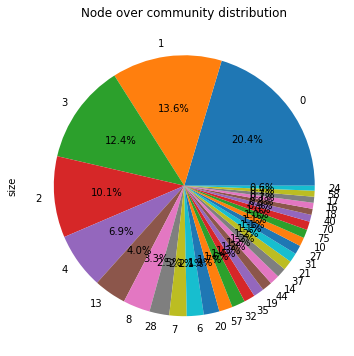

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.050673,1072.0,0.849748,1142174.0,0.461639,1072.0,0.003676,1072.0,1.0,148.0
1,0.025802,363.0,0.533918,1072.0,0.228822,363.0,0.003213,482709.0,1.0,706546.0
2,0.018435,106.0,0.467370,53223.0,0.097320,106.0,0.002734,106.0,1.0,1053204.0
3,0.017203,482709.0,0.382376,56862.0,0.082068,929.0,0.002406,663931.0,1.0,694431.0
4,0.015584,663931.0,0.081036,929.0,0.077487,2526.0,0.001824,929.0,1.0,135324.0
5,0.013952,929.0,0.029773,1529.0,0.074129,1245.0,0.001361,808.0,1.0,685868.0
6,0.010753,808.0,0.027954,664320.0,0.059040,808.0,0.001293,663606.0,1.0,546407.0
7,0.007793,663606.0,0.025590,363.0,0.057543,663560.0,0.001187,363.0,1.0,842797.0
8,0.007495,480.0,0.023595,9162.0,0.051369,480.0,0.001158,832.0,1.0,572376.0
9,0.007432,832.0,0.018985,14251.0,0.046500,482709.0,0.001048,1191.0,1.0,175356.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.007669,1846.0,0.150245,701383.0,0.084332,1846.0,0.000450,6511.0,1.0,1066959.0
1,0.004631,311.0,0.023085,7731.0,0.061515,311.0,0.000352,38385.0,1.0,1121365.0
2,0.003047,617.0,0.018697,667116.0,0.043072,617.0,0.000237,1846.0,1.0,455551.0
3,0.003047,6511.0,0.018379,18106.0,0.032710,6430.0,0.000223,102904.0,1.0,430717.0
4,0.002904,38385.0,0.014089,664251.0,0.031933,701.0,0.000217,78452.0,1.0,418411.0
5,0.002501,13025.0,0.010726,3512.0,0.030802,18173.0,0.000195,20324.0,1.0,429237.0
6,0.002268,18173.0,0.006631,663921.0,0.030539,13025.0,0.000173,107601.0,1.0,423148.0
7,0.001946,6430.0,0.005764,33033.0,0.029464,1013.0,0.000165,75045.0,1.0,1113307.0
8,0.001933,1013.0,0.005001,92973.0,0.028380,10844.0,0.000130,94060.0,1.0,428565.0
9,0.001875,16173.0,0.004843,20015.0,0.028271,21160.0,0.000129,123843.0,1.0,1070989.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003473,3100.0,0.002135,18859.0,0.037746,3100.0,0.000335,4956.0,1.0,143809.0
1,0.002571,4936.0,0.001423,4936.0,0.025772,1705.0,0.000323,667698.0,1.0,195946.0
2,0.002478,18859.0,0.001385,3100.0,0.017688,8387.0,0.000320,3100.0,1.0,127226.0
3,0.002183,168.0,0.001262,34.0,0.013429,4936.0,0.000313,18859.0,1.0,161501.0
4,0.002069,4987.0,0.001104,168.0,0.013242,94.0,0.000302,4890.0,1.0,624907.0
5,0.002065,4736.0,0.000886,18675.0,0.012658,168.0,0.000280,4222.0,1.0,607945.0
6,0.002046,4083.0,0.000884,8387.0,0.012225,4236.0,0.000248,3949.0,1.0,852466.0
7,0.001875,4222.0,0.000825,4890.0,0.011775,4083.0,0.000228,3803.0,1.0,556150.0
8,0.001870,1705.0,0.000731,4736.0,0.011150,34.0,0.000225,4736.0,1.0,127288.0
9,0.001864,34.0,0.000652,1705.0,0.010406,4890.0,0.000223,4987.0,1.0,548193.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.009504,27837.0,0.007999,113834.0,0.064858,2687.0,0.001179,27837.0,1.0,1043224.0
1,0.008633,108624.0,0.006779,676239.0,0.055166,2633.0,0.001130,108624.0,1.0,109137.0
2,0.008595,2687.0,0.005335,254987.0,0.053773,44006.0,0.001082,2687.0,1.0,347557.0
3,0.007691,2633.0,0.002452,146352.0,0.048469,27837.0,0.000824,110105.0,1.0,754309.0
4,0.005569,3425.0,0.002300,108624.0,0.045032,21171.0,0.000744,268337.0,1.0,316309.0
5,0.005488,44006.0,0.001916,2687.0,0.044549,2549.0,0.000730,2633.0,1.0,117997.0
6,0.005463,115674.0,0.001573,20364.0,0.044210,2317.0,0.000713,155432.0,1.0,127880.0
7,0.005329,21171.0,0.001553,110105.0,0.043950,38338.0,0.000698,20364.0,1.0,688713.0
8,0.005273,155432.0,0.001519,8746.0,0.041636,62876.0,0.000651,104137.0,1.0,1092649.0
9,0.005153,115241.0,0.001348,2633.0,0.040702,2283.0,0.000651,280436.0,1.0,747142.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.019880,35661.0,0.010467,744172.0,0.008350,17343.0,0.006388,35661.0,1.0,1030544.0
1,0.004869,697672.0,0.010466,35661.0,0.006911,26085.0,0.001476,697672.0,1.0,925049.0
2,0.003977,683704.0,0.002022,697672.0,0.005954,3026.0,0.001040,108602.0,1.0,906571.0
3,0.003643,108602.0,0.002014,108602.0,0.005320,22821.0,0.000908,683704.0,1.0,924994.0
4,0.003391,26085.0,0.001919,26085.0,0.005119,108602.0,0.000801,1024068.0,1.0,937248.0
5,0.003320,678519.0,0.001363,683704.0,0.005104,22846.0,0.000770,667325.0,1.0,931562.0
6,0.003278,667325.0,0.001122,17343.0,0.004966,3018.0,0.000727,26085.0,1.0,1091329.0
7,0.002873,686285.0,0.001060,668899.0,0.004948,25563.0,0.000703,678519.0,1.0,591814.0
8,0.002800,697499.0,0.001007,1024068.0,0.004836,86341.0,0.000695,668899.0,1.0,937019.0
9,0.002610,705285.0,0.000961,667325.0,0.004791,640.0,0.000597,780027.0,1.0,1115647.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001783,1099803.0,0.000700,1099803.0,0.002739,49382.0,0.000516,1099803.0,1.0,1129962.0
1,0.000208,1059739.0,0.000249,1059739.0,0.002738,84402.0,0.000054,1059739.0,1.0,1135442.0
2,0.000190,12115.0,0.000094,12115.0,0.002619,1099803.0,0.000051,12115.0,1.0,500920.0
3,0.000106,1127791.0,0.000055,336478.0,0.002441,201007.0,0.000028,1127614.0,1.0,1138362.0
4,0.000106,1127614.0,0.000039,1127791.0,0.002390,288115.0,0.000027,819174.0,1.0,1157479.0
5,0.000083,5116.0,0.000034,58923.0,0.002319,139758.0,0.000023,1127791.0,1.0,1122572.0
6,0.000079,668749.0,0.000033,819174.0,0.002292,199606.0,0.000021,782648.0,1.0,1135364.0
7,0.000072,58923.0,0.000028,1127614.0,0.002270,70909.0,0.000018,842067.0,1.0,1157474.0
8,0.000072,336478.0,0.000025,899711.0,0.002253,107548.0,0.000018,668749.0,1.0,1122501.0
9,0.000070,819174.0,0.000024,5116.0,0.002221,200984.0,0.000017,58923.0,1.0,1130024.0


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.6053287495054115
Number of communities: 38852


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

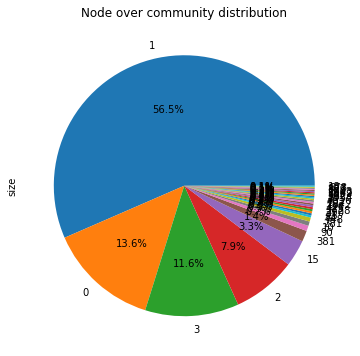

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.025802,363.0,0.027954,664320.0,0.228822,363.0,0.002734,106.0,1.0,148.0
1,0.018435,106.0,0.025590,363.0,0.097320,106.0,0.001187,363.0,1.0,905748.0
2,0.007495,480.0,0.014686,106.0,0.057543,663560.0,0.000821,384.0,1.0,66541.0
3,0.006179,663560.0,0.010938,3198.0,0.051369,480.0,0.000802,480.0,1.0,99693.0
4,0.005981,803.0,0.005478,1034018.0,0.046244,210.0,0.000718,1025.0,1.0,207369.0
5,0.005349,384.0,0.004857,4.0,0.044484,803.0,0.000623,773.0,1.0,70770.0
6,0.005051,517.0,0.004633,480.0,0.044385,404.0,0.000613,688.0,1.0,258684.0
7,0.004933,664789.0,0.003965,210.0,0.037961,104.0,0.000547,803.0,1.0,185193.0
8,0.004852,4.0,0.003874,663560.0,0.037672,806.0,0.000546,104.0,1.0,198950.0
9,0.004832,773.0,0.002985,675020.0,0.037427,4.0,0.000543,4.0,1.0,169656.0


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.050673,1072.0,0.849748,1142174.0,0.461639,1072.0,0.003676,1072.0,1.0,593982.0
1,0.013952,929.0,0.533918,1072.0,0.084332,1846.0,0.001824,929.0,1.0,816180.0
2,0.010753,808.0,0.467370,53223.0,0.082068,929.0,0.001361,808.0,1.0,941082.0
3,0.007669,1846.0,0.382376,56862.0,0.077487,2526.0,0.001048,1191.0,1.0,502255.0
4,0.007127,1245.0,0.150245,701383.0,0.074129,1245.0,0.000805,682734.0,1.0,860141.0
5,0.006533,1191.0,0.081036,929.0,0.061515,311.0,0.000760,20012.0,1.0,497207.0
6,0.006381,2526.0,0.034485,1219.0,0.059040,808.0,0.000717,4719.0,1.0,399729.0
7,0.005209,4719.0,0.029773,1529.0,0.043655,357531.0,0.000698,20364.0,1.0,481559.0
8,0.004966,1432.0,0.023595,9162.0,0.043072,617.0,0.000694,20922.0,1.0,494584.0
9,0.004631,311.0,0.023085,7731.0,0.042034,1491.0,0.000573,1432.0,1.0,68209.0


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002571,4936.0,0.002135,18859.0,0.013429,4936.0,0.000313,18859.0,1.0,456095.0
1,0.002478,18859.0,0.001423,4936.0,0.013242,94.0,0.000280,4222.0,1.0,158355.0
2,0.002183,168.0,0.001262,34.0,0.012658,168.0,0.000248,3949.0,1.0,796925.0
3,0.002069,4987.0,0.001104,168.0,0.012225,4236.0,0.000228,3803.0,1.0,467934.0
4,0.002065,4736.0,0.000886,18675.0,0.011775,4083.0,0.000225,4736.0,1.0,377351.0
5,0.002046,4083.0,0.000731,4736.0,0.011150,34.0,0.000223,4987.0,1.0,140057.0
6,0.001875,4222.0,0.000650,8875.0,0.010203,1709.0,0.000205,8875.0,1.0,374824.0
7,0.001864,34.0,0.000560,8835.0,0.009467,3949.0,0.000204,18675.0,1.0,956556.0
8,0.001827,3949.0,0.000527,3949.0,0.009315,4050.0,0.000187,4236.0,1.0,836489.0
9,0.001625,4050.0,0.000503,72400.0,0.009022,8835.0,0.000173,4782.0,1.0,917552.0


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.009504,27837.0,0.005335,254987.0,0.064858,2687.0,0.001179,27837.0,1.0,771435.0
1,0.008633,108624.0,0.002300,108624.0,0.055166,2633.0,0.001130,108624.0,1.0,420751.0
2,0.008595,2687.0,0.001916,2687.0,0.053773,44006.0,0.001082,2687.0,1.0,121105.0
3,0.007691,2633.0,0.001553,110105.0,0.048469,27837.0,0.000824,110105.0,1.0,119436.0
4,0.005569,3425.0,0.001519,8746.0,0.045032,21171.0,0.000730,2633.0,1.0,420738.0
5,0.005488,44006.0,0.001348,2633.0,0.044549,2549.0,0.000713,155432.0,1.0,253280.0
6,0.005463,115674.0,0.001321,21473.0,0.044210,2317.0,0.000651,104137.0,1.0,119328.0
7,0.005329,21171.0,0.001151,27837.0,0.043950,38338.0,0.000651,280436.0,1.0,423662.0
8,0.005273,155432.0,0.001133,115241.0,0.041636,62876.0,0.000613,115674.0,1.0,110174.0
9,0.005153,115241.0,0.001044,21171.0,0.040702,2283.0,0.000612,115241.0,1.0,402185.0


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000275,138993.0,0.000138,138964.0,0.003841,138964.0,0.000030,138993.0,1.0,795326.0
1,0.000256,71019.0,0.000079,71019.0,0.001711,62368.0,0.000022,145543.0,1.0,448415.0
2,0.000215,24373.0,0.000053,24373.0,0.001331,23503.0,0.000021,24373.0,1.0,263537.0
3,0.000213,145260.0,0.000047,138993.0,0.001318,4255.0,0.000021,71019.0,1.0,508151.0
4,0.000139,23503.0,0.000037,145260.0,0.001302,155884.0,0.000021,268091.0,1.0,391542.0
5,0.000132,145543.0,0.000033,145543.0,0.001288,24373.0,0.000015,145260.0,1.0,508149.0
6,0.000127,88596.0,0.000033,23503.0,0.001255,41701.0,0.000011,88596.0,1.0,153403.0
7,0.000127,61351.0,0.000031,149466.0,0.001097,145349.0,0.000011,145167.0,1.0,457557.0
8,0.000120,268091.0,0.000023,268091.0,0.000462,486498.0,0.000010,88591.0,1.0,453951.0
9,0.000116,149457.0,0.000019,145170.0,0.000404,62371.0,0.000010,23503.0,1.0,565838.0


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000612,1650.0,0.000448,1650.0,0.005589,1650.0,0.000094,1650.0,1.0,728994.0
1,0.000067,1353.0,0.000019,1353.0,0.001460,8801.0,0.000005,1353.0,1.0,652808.0
2,0.000046,85063.0,0.000009,282364.0,0.001229,1353.0,0.000004,194939.0,1.0,1014310.0
3,0.000044,194939.0,0.000009,85063.0,0.000489,14930.0,0.000004,85063.0,1.0,91705.0
4,0.000039,91736.0,0.000006,91715.0,0.000394,91734.0,0.000004,91715.0,1.0,91706.0
5,0.000032,1687.0,0.000005,88926.0,0.000262,1438.0,0.000003,678603.0,1.0,91747.0
6,0.000028,8801.0,0.000004,348392.0,0.000169,1687.0,0.000003,728995.0,1.0,668166.0
7,0.000026,1438.0,0.000004,91675.0,0.000107,50825.0,0.000003,348392.0,1.0,91718.0
8,0.000025,91734.0,0.000004,1438.0,0.000095,1484.0,0.000003,91736.0,1.0,91713.0
9,0.000023,91715.0,0.000004,678583.0,0.000095,668166.0,0.000002,1438.0,1.0,678579.0


No timestamp data available
